## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Load Dataset

In [271]:
raw_data = pd.read_csv("Online_Retail.csv")
# ,parse_dates=['InvoiceDate']
raw_data.head(50)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01/12/10 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01/12/10 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01/12/10 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01/12/10 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01/12/10 08:34,1.69,13047.0,United Kingdom


## Convert to Time series data

In [230]:
sales_data = raw_data.drop(['InvoiceNo','Description','CustomerID','Country','UnitPrice'], axis = 1)
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])
# sales_data=sales_data.set_index(['InvoiceDate'])
sales_data.info()
sales_data.index
# sales_data.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
StockCode      541909 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.4+ MB


RangeIndex(start=0, stop=541909, step=1)

In [189]:
# dates = sales_data.drop(['StockCode','Quantity'],axis =1)
# dates['InvoiceDate'] = pd.to_datetime(dates['InvoiceDate'])
# dates['InvoiceDate'] = dates['InvoiceDate'].dt.date

,InvoiceDate
0,2010-01-12
1,2010-01-12
2,2010-01-12
3,2010-01-12
4,2010-01-12


In [196]:
# (dates.InvoiceDate.min(),dates.InvoiceDate.max())
# dates.head()

(datetime.date(2010, 1, 12), datetime.date(2011, 12, 10))

### Extracting one product out and DownSampling

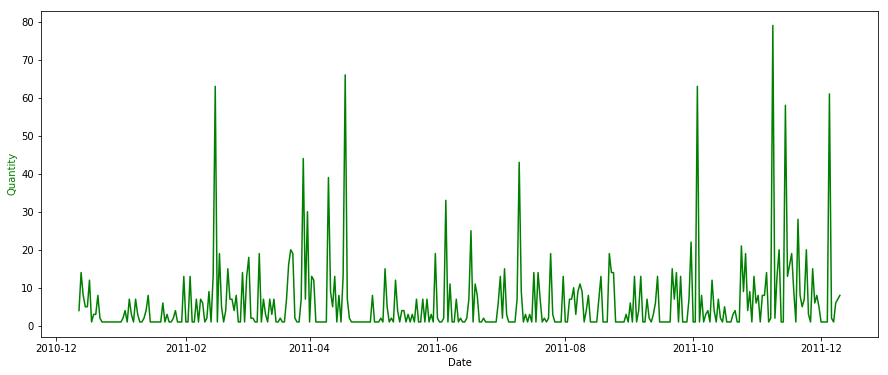

In [360]:
#pull out all transactions of one product and drop StockCode
product = sales_data.loc[sales_data['StockCode'] == '22745'].drop('StockCode',axis=1)
product=product.set_index(['InvoiceDate']) #Convert to timeseries 

#DownSampling to a day
day_summary = pd.DataFrame()
day_summary['Quantity'] = product.Quantity.resample('D').sum()
day_summary = day_summary.fillna(0) #replacing NaN with 0
day_summary = day_summary.clip(0) #replace -ve values with 0

day_summary = day_summary['2010-12-12':]#trim as almost no data available before this date
day_summary['Quantity']+=1#ti avoid -inf while taking log transformation 

#plot
fig, ax1 = plt.subplots()
ax1.plot(day_summary.index, day_summary['Quantity'], 'g-')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quantity', color='g')
# ax1.set_ylim(0,100)
plt.show()

## Stationarity check

In [361]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

#     #Plot rolling statistics:
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput[0]<dfoutput[4]:
        print("90% Stationary")
    elif dfoutput[0]<dfoutput[5]:
        print("99% Stationary")
    elif dfoutput[0]<dfoutput[6]:
        print("95% Stationary")
    else:
        print("not Stationary")
    
test_stationarity(day_summary.Quantity)

Results of Dickey-Fuller Test:
Test Statistic                  -5.541439
p-value                          0.000002
#Lags Used                       6.000000
Number of Observations Used    357.000000
Critical Value (10%)            -2.571101
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
dtype: float64
90% Stationary


/home/hitkul/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
  
/home/hitkul/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()
  import sys


## Eliminating Trend

### exponential weighted moving average

In [362]:
day_summary_log = np.log(day_summary)

expwighted_avg = pd.ewma(day_summary_log, halflife=5)
day_summary_log_ewma_diff = day_summary_log - expwighted_avg
day_summary_log_ewma_diff = day_summary_log_ewma_diff.clip(0)
day_summary_log_ewma_diff
test_stationarity(day_summary_log_ewma_diff.Quantity)

Results of Dickey-Fuller Test:
Test Statistic                -1.086993e+01
p-value                        1.376751e-19
#Lags Used                     3.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (10%)          -2.571065e+00
Critical Value (1%)           -3.448646e+00
Critical Value (5%)           -2.869602e+00
dtype: float64
90% Stationary


/home/hitkul/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,halflife=5).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hitkul/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
  
/home/hitkul/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()
  import sys


As we can see Simple methods like Log transformation and exponential weighted moving average does not help in improving stationarity in our case

### Differencing

             Quantity
InvoiceDate          
2010-12-13   1.252763
2010-12-14  -0.559616
2010-12-15  -0.470004
2010-12-16   0.000000
2010-12-17   0.875469
Results of Dickey-Fuller Test:
Test Statistic                -7.911601e+00
p-value                        3.934555e-12
#Lags Used                     1.700000e+01
Number of Observations Used    3.450000e+02
Critical Value (10%)          -2.571253e+00
Critical Value (1%)           -3.449447e+00
Critical Value (5%)           -2.869954e+00
dtype: float64
90% Stationary


/home/hitkul/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
  
/home/hitkul/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()
  import sys


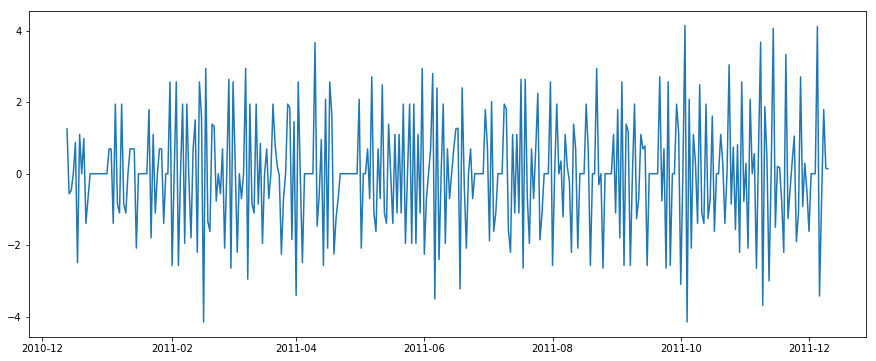

In [363]:
day_summary_log_diff = day_summary_log - day_summary_log.shift()
day_summary_log_diff.dropna(inplace=True)
# day_summary_log_diff = day_summary_log_diff.fillna(0) #replacing NaN with 0
# day_summary_log_diff = day_summary_log_diff.clip(0)
print(day_summary_log_diff.head())
plt.plot(day_summary_log_diff)
test_stationarity(day_summary_log_diff.Quantity)

Because of the nature of our series there is no significant increase in Stationary values but we have sucesfully removed seasonality and trends from our series.

## ARIMA
### ACF and PACF

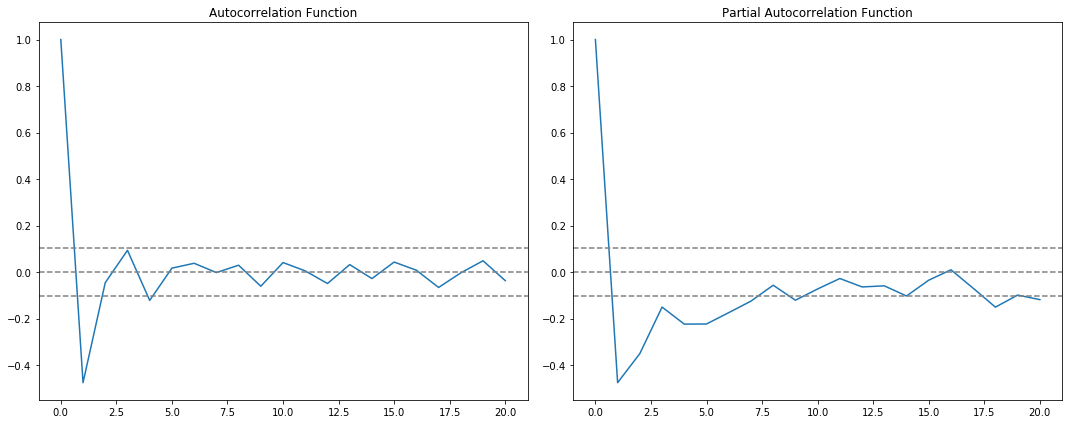

In [365]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(day_summary_log_diff, nlags=20)
lag_pacf = pacf(day_summary_log_diff, nlags=20, method='ols')


#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(day_summary_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(day_summary_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(day_summary_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(day_summary_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()